This notebook acquires data to measure the gain of the SiPM. It sets the overvoltage and then takes scope and MCA data with the Red Pitaya. The scope is setup to trigger on the LED.

In [1]:
import numpy as np
import time,datetime
import matplotlib.pyplot as plt
plt.style.use('../../style.mplstyle')
import sys 
sys.path.append("../../devices")
sys.path.append("../../RedPitaya")
from datetime import datetime

In [2]:
#### set data taking parameters here #####

save_dir = "" ## name of director to save, leave empty to use todays date as default
make_plots = True ## make diagnostic plots

breakdown_voltage = 27 ## Volts, breakdown to sweep keithley relative to
ov_list = np.linspace(2, 6, 10)[:2] ## Volts, list of overvoltages to sweep

red_pitaya_channel = 2 ## channel for the analog signal in the RP (1 or 2)

num_scope_traces = 10 ## number of traces at each overvoltage
num_mca_events = 10000 ## number of MCA pulses in the histogram
LED_flashing_rate = 1000 ## Hz, rate at which to pulse LED

In [3]:
## setup directories for saving data

date = datetime.today().strftime('%Y%m%d')

path = "C:/Data/%s/"%date
if not os.path.exists(path):
    os.makedirs(path)

In [4]:
## import instrument control as needed
from pitaya import RedPitaya
from functiongenerator import AFG2225
from picoammeter import Keithley6487
from powersupply import NGE100
import redpitaya_mca as mca

In [5]:
nge = NGE100('USB0::0x0AAD::0x0197::5601.1414k03-100771::INSTR')
pico = Keithley6487('ASRL9::INSTR')
func = AFG2225('ASRL19::INSTR')

In [6]:
## turn on 24 Volts to power the cremat pre-amplifier
output_channel = 1 ## channel to turn on
output_voltage = 24 # Volts
nge.output(ch=output_channel, state=False)
nge.voltage(ch=output_channel, volt=output_voltage)
nge.output(ch=output_channel, state=True)

In [7]:
# set the function generator to trigger the LED
synth_channel = 2
pulse_frequency = LED_flashing_rate ## Hz, rate of pulses
pulse_amplitude = 5 ## V, voltage for driving LED
amplitude_offset = pulse_amplitude/2 ## V, offset to give positive going pulse

func.set_frequency(synth_channel, pulse_frequency)
func.set_amplitude(synth_channel, pulse_amplitude)
func.set_offset(synth_channel, amplitude_offset)
func.set_output_load(synth_channel, "HZ") ## make sure the channel is set for high impedance
func.set_output_onoff(synth_channel, 1) ## turn on channel

True

In [8]:
## setup the Keithley and turn it on to the breakdown voltage so it starts ramping up

keithley_time_delay = 5 ## seconds, time to wait for the keithley to stabilize at a given voltage

pico.voltage_source_state(0) ## turn off source
pico.voltage_source_range(breakdown_voltage+np.max(ov_list)) ## set the range to accomodate the highest voltage needed
pico.voltage(breakdown_voltage) ## set to breakdown
pico.voltage_source_state(1) ## turn on source
time.sleep(keithley_time_delay) ## wait for the voltage to ramp up

In [9]:
## setup the Red Pitaya for waveform acquisition and for the MCA

## parameters for scope acquisition (via SCPI)
rp_size = 2048 ## number of samples to acquire
rp_delay = 8192-rp_size/2. ## trigger delay relative to start of the waveform


In [10]:
## helper function to take waveform data

def get_waveform_data(rp, chan, num_wfs, trig='ext', trig_params = {'ch': 2, 'level': 20, 'delay': rp_delay}):
    
    wvf_array=[]
    for wf_idx in range(num_wfs):
        rp.configure(dec_fac=64)
        rp.start()
        
        if trig == 'ext':
            rp.ext_trigger()
        elif trig in [1,2]:
            rp.trigger(**trig_params)
        else:
            print("Trigger must be '''ext''' or 1,2 for channel")
            return None

        t, data = rp.acquire(ch=chan, size=rp_size, ascii=True)
        wvf_array.append(data)

    return np.array(wvf_array), t

!!!! Before running this cell make sure the SCPI server is running !!!

Red pitaya SCPI server stopped


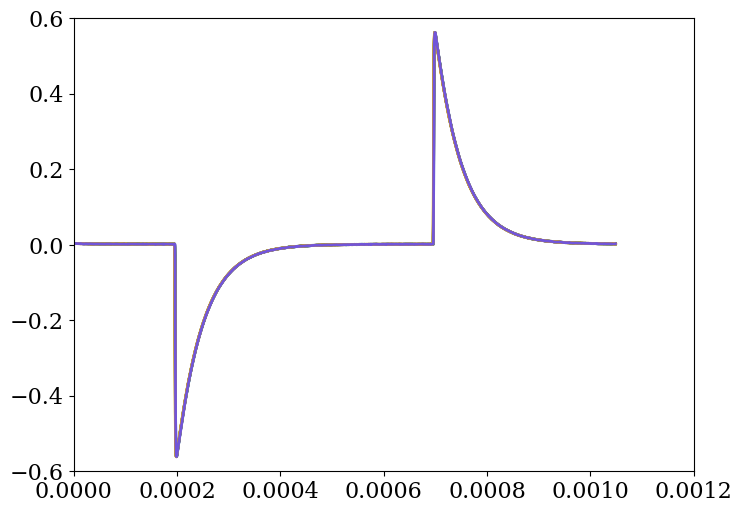

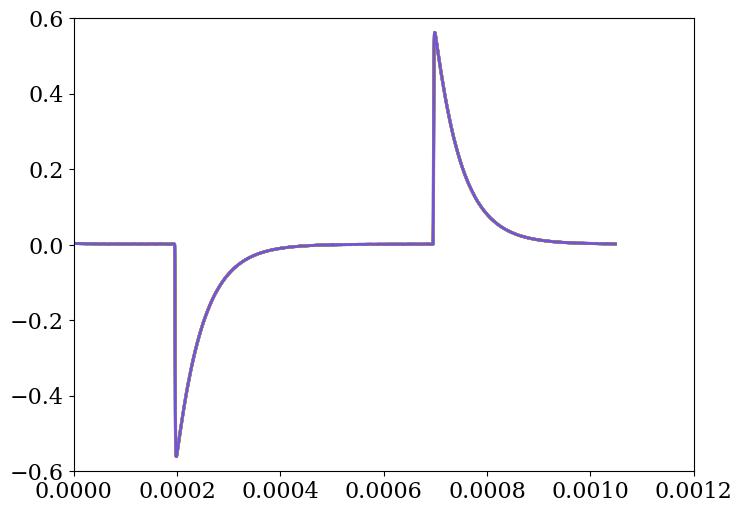

In [13]:
## loop over overvoltages, and set the keithley. then take scope and MCA data as desired

red = RedPitaya('172.28.175.57', username='root', password='root')

for ov in ov_list:

    ## set keithley to desired voltage (assumes wired reverse biased, so positive voltages):
    pico.voltage(breakdown_voltage + ov) 
    time.sleep(keithley_time_delay) ## wait for voltage to ramp up

    wf_data, t = get_waveform_data(red, red_pitaya_channel, num_scope_traces)        
    red.save(t, wf_data, ch=red_pitaya_channel, tag='keith_{:.2f}OV'.format(ov), path=path)

    if(make_plots):
        plt.figure()
        plt.plot(t, wf_data.T)
        plt.show()   

!!!! Before running this section, make sure to start the MCA app via the web interface !!!

In [18]:
def get_mca_data(integ_time, channel_to_use):

    rp = mca.mca()

    rp.setup_mca(chan=channel_to_use, baseline_level=0)
    rp.reset_histo(chan=channel_to_use)
    rp.start_histo(chan=channel_to_use)

    time.sleep(integ_time)

    dat = []
    while(len(dat) == 0):
        dat = rp.read_histo_data(chan=channel_to_use)

    rp.close()

    return dat

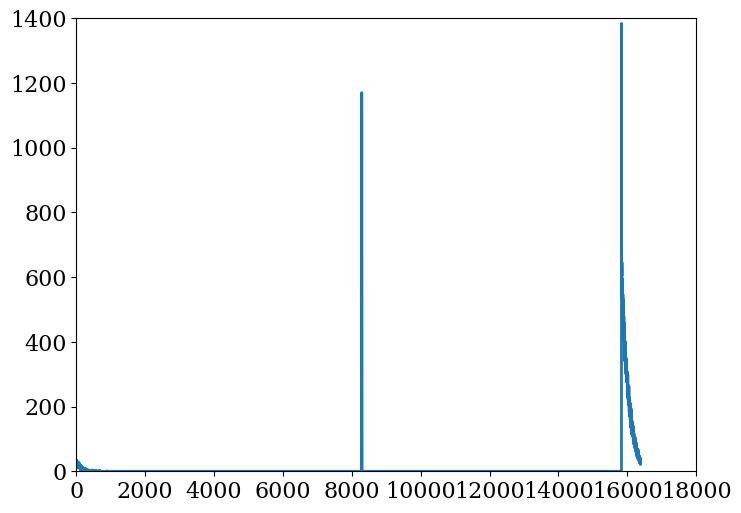

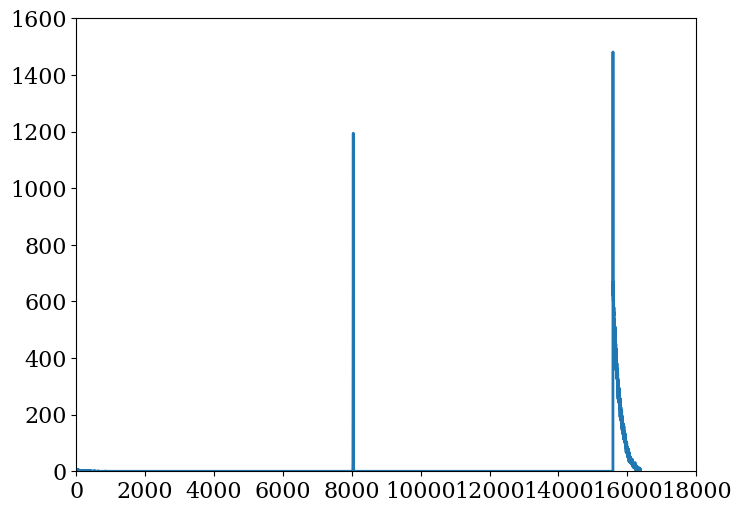

In [19]:


int_time = num_mca_events/LED_flashing_rate

for ov in ov_list:

    ## set keithley to desired voltage (assumes wired reverse biased, so positive voltages):
    pico.voltage(breakdown_voltage + ov) 
    time.sleep(keithley_time_delay) ## wait for voltage to ramp up

    data = get_mca_data(int_time, red_pitaya_channel-1)

    if(make_plots):
        plt.figure()
        plt.plot(data)
        plt.show()   